# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания (RMSE не более 2500);
- скорость предсказания;
- время обучения.

## Подготовка данных

Импортируем библиотеки, функции, откроем на данные и взглянем на них.

In [4]:
!pip install -q category_encoders
!pip install -q scikit-optimize

In [5]:
import time
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
from scipy import stats

from sklearn.metrics import mean_squared_error as mse

from sklearn.experimental import enable_halving_search_cv

from skopt import BayesSearchCV
from skopt.callbacks import DeltaYStopper
from sklearn.model_selection import train_test_split
from category_encoders.binary import BinaryEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import lightgbm as lgb

STATE = np.random.RandomState(1234)

In [6]:
data = pd.read_csv("/datasets/autos.csv")

data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Из сопроводительной информации:  

**Признаки**
  - DateCrawled — дата скачивания анкеты из базы  
  - VehicleType — тип автомобильного кузова  
  - RegistrationYear — год регистрации автомобиля  
  - Gearbox — тип коробки передач  
  - Power — мощность (л. с.)  
  - Model — модель автомобиля  
  - Kilometer — пробег (км)  
  - RegistrationMonth — месяц регистрации автомобиля  
  - FuelType — тип топлива  
  - Brand — марка автомобиля  
  - Repaired — была машина в ремонте или нет  
  - DateCreated — дата создания анкеты  
  - NumberOfPictures — количество фотографий автомобиля  
  - PostalCode — почтовый индекс владельца анкеты (пользователя)  
  - LastSeen — дата последней активности пользователя  
  
**Целевой признак**
  - Price — цена (евро)

Приведём названия колонок к snake_case.

In [7]:
def change_column_names(df):
    
    orig_columns_list = df.columns.tolist()
    new_columns_list = []
    
    for column_name in orig_columns_list:
        new_column_name=""
        new_column_name+=column_name[0].lower()
        for i in range(1,len(column_name)):
            if(column_name[i].isupper()):
                new_column_name+="_"+column_name[i].lower()
            else:
                new_column_name+=column_name[i]
        new_columns_list.append(new_column_name)
        
    rename_dict = {}    
    for i in range(len(orig_columns_list)):
        rename_dict[orig_columns_list[i]] = new_columns_list[i]
    return rename_dict

In [8]:
data = data.rename(columns = change_column_names(data))

data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Проверим наличие дубликатов, и устраним, если найдём.

In [9]:
data.duplicated().sum()

4

In [10]:
data=data.drop_duplicates().reset_index(drop=True)

Приведём даты к datetime.

In [11]:
for column in ['date_crawled', 'date_created', 'last_seen']:
    data[column] = pd.to_datetime(data[column], format='%Y-%m-%d %H:%M:%S')
data.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             334532 non-null  object        
 5   power               354365 non-null  int64         
 6   model               334660 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           321470 non-null  object        
 10  brand               354365 non-null  object        
 11  repaired            283211 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 no

Видим наличие пропусков, выведем на экран их количества.

In [12]:
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Наибольшее количество пропусков - в пункте, касающемся ремонтов.

In [13]:
data['repaired'].value_counts(normalize = True, dropna = False)

no     0.697467
NaN    0.200793
yes    0.101740
Name: repaired, dtype: float64

Заполним их значением unknown - мы не можем достоверно установить, была ли машина в ремонте, из данных фрейма. Предположение "если машина была в ремонте, об этом бы написали" не очень вероятно.

In [14]:
data.loc[data['repaired'].isna() == True, 'repaired'] = 'unknown'
data['repaired'].value_counts(normalize = True, dropna = False)

no         0.697467
unknown    0.200793
yes        0.101740
Name: repaired, dtype: float64

Теперь посмотрим на строчки с пропуском в vehicle_type: может, мы сможем заполнить их из данных фрейма, ссылаясь на похожие строки?

In [15]:
data[data['vehicle_type'].isna() == True]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,unknown,2016-04-01,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,unknown,2016-03-29,0,37075,2016-03-29 17:43:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354342,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,unknown,2016-03-07,0,61169,2016-03-08 21:28:38
354347,2016-03-11 23:40:32,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11,0,87700,2016-03-12 14:16:51
354357,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09,0,51371,2016-03-13 01:44:13
354360,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49


Посмотрим на строки, похоже на первую, у которых отсутствуют пропуски в vehicle type.

In [16]:
data[(data['vehicle_type'].isna() == False) & (data['model'] == 'golf') & (data['registration_year'] == 1993)]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
158,2016-04-01 16:06:24,800,sedan,1993,manual,0,golf,10000,9,petrol,volkswagen,yes,2016-04-01,0,65929,2016-04-07 11:17:07
253,2016-03-25 08:52:58,300,small,1993,manual,90,golf,150000,8,petrol,volkswagen,unknown,2016-03-25,0,27412,2016-04-04 06:22:54
2117,2016-04-02 10:52:34,270,small,1993,manual,75,golf,150000,4,petrol,volkswagen,no,2016-04-02,0,49152,2016-04-04 07:51:01
2881,2016-03-15 19:46:26,650,sedan,1993,auto,75,golf,150000,3,petrol,volkswagen,no,2016-03-15,0,84186,2016-04-06 23:46:51
3186,2016-03-28 17:44:12,150,small,1993,manual,60,golf,150000,2,petrol,volkswagen,yes,2016-03-28,0,9456,2016-03-30 08:46:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352360,2016-03-29 20:55:59,750,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-29,0,23562,2016-04-06 07:17:26
352730,2016-03-17 16:56:40,900,small,1993,manual,60,golf,125000,8,petrol,volkswagen,no,2016-03-17,0,44359,2016-03-20 19:19:18
352862,2016-03-31 12:57:08,250,sedan,1993,manual,60,golf,150000,3,petrol,volkswagen,no,2016-03-31,0,31712,2016-04-06 05:44:26
354043,2016-03-05 14:18:10,1000,sedan,1993,manual,75,golf,150000,2,petrol,volkswagen,no,2016-03-04,0,35767,2016-03-06 04:45:43


Однозначно установить тип кузова по данным фрейма не получится. Заполним все пропуски в фрейме значением unknown.

In [17]:
data = data.fillna('unknown')
data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Сделаем список категориальных переменных и посчитаем на будущее, сколько же у нас получится столбцов при использовании OHE.
Обратим внимание - почтовый код, по сути - категориальная переменная. 

In [18]:
cat_features = ['vehicle_type','gearbox','model','fuel_type','brand','repaired', 'postal_code']

sum_unique = 0
for column in cat_features:
    sum_unique += len(data[column].unique())
    print(f"{len(data[column].unique())} уникальных значений в столбце {column}")
    
print()
print(f"Из {len(cat_features)} столбцов получится {sum_unique - len(cat_features)} столбцов при использовании OHE")

9 уникальных значений в столбце vehicle_type
3 уникальных значений в столбце gearbox
251 уникальных значений в столбце model
8 уникальных значений в столбце fuel_type
40 уникальных значений в столбце brand
3 уникальных значений в столбце repaired
8143 уникальных значений в столбце postal_code

Из 7 столбцов получится 8450 столбцов при использовании OHE


Это означает, что мы не будем пользоваться OHE.  
Воспользуемся Binary Encoder из библиотеки category_encoders.

Посмотрим на распределение числовых переменных.

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
90%,11450.000000,2012.000000,179.000000,150000.000000,11.000000,0.0,87776.000000
95%,14600.000000,2016.000000,218.000000,150000.000000,12.000000,0.0,93109.000000
99%,18800.000000,2018.000000,300.000000,150000.000000,12.000000,0.0,98596.000000


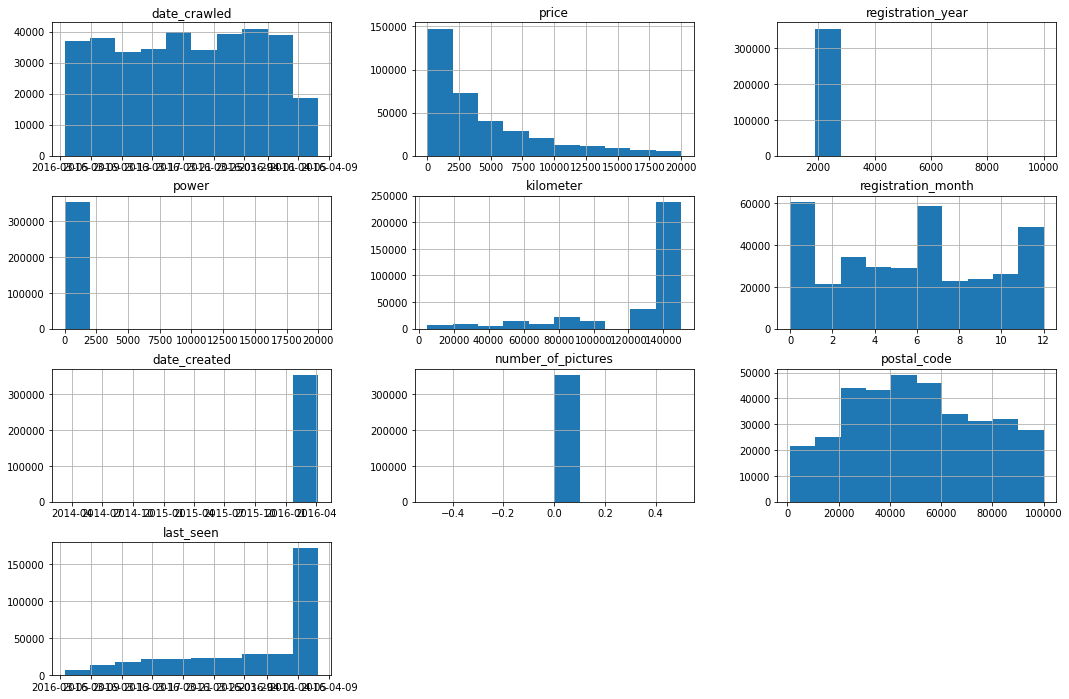

In [19]:
data.hist(figsize = (18,12));
data.describe(percentiles = [0.25,0.5,0.75,0.9,0.95,0.99])

Колонка number_of_pictures пустая. Исключим её из датафрейма и из перечня числовых переменных.

In [20]:
data = data.drop(columns = 'number_of_pictures')

Значения цен слишком близко распределены около нуля и есть нулевые. Хочу их отбросить, если их не очень много: нулевых продаж не бывает. Посмотрим на их долю.

In [21]:
data['price'].value_counts(normalize = True)[[0]]

0    0.030398
Name: price, dtype: float64

Определим функцию для условного отбрасывания нежелательных строк, это ещё пригодится.

In [22]:
def drop_by_query(df, query):
    display(df.shape[0])
    df = df.query(query)
    display(df.shape[0])
    return df

Отбросим строки с нулевыми значениями.

In [23]:
data = drop_by_query(data, 'price > 0')

354365

343593

Кажется, есть нулевые значения в поле месяц регистрации. Проверим, правда ли у нас в датафрейме 13 месяцев.

In [24]:
len(data['registration_month'].unique())

13

А в нулевой месяц платят тринадцатую зарплату? Шутка.  

Сделаем список случайных значений месяцев на основе нашего фрейма, для того, чтобы сохранить распределение, и перезапишем ими нулевые значения.

In [25]:
random_month_list = data.query('registration_month != 0')['registration_month']\
.sample(n=len(data.loc[data['registration_month'] == 0])).tolist()

index_list = data.loc[data['registration_month'] == 0].index.tolist()

for i in tqdm(range(len(random_month_list))):
    data.loc[index_list[i],'registration_month'] = random_month_list[i]

data['registration_month'].describe()

  0%|          | 0/32881 [00:00<?, ?it/s]

count    343593.000000
mean          6.392071
std           3.349784
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64

Напишем функцию для исследования выбросов. Применим её последовательно на годе регистрации и мощности авто.

In [26]:
def outlier_frame(df, column, lower = 0.1, higher=99.9):
    outlier_frame = df[(df[column] < np.percentile(df[column], lower)) | \
     (df[column] > np.percentile(df[column], higher))][column].value_counts()\
.to_frame(name='count').reset_index().rename(columns = {'index':column}).sort_values(by=column)
    display(f"Значений-выбросов: {outlier_frame.shape[0]}")
    return outlier_frame

In [27]:
outlier_year = outlier_frame(data,'registration_year')

'Значений-выбросов: 81'

Посмотрим на выбросы: какие у нас есть минимальные и максимальные годы. Минимальные посмотрим через .head(), максимальные - через срез: вытянем из date_crawled год и выберем максимальный, его и используем.

In [28]:
max_year = data['date_crawled'].max().year
display(outlier_year.head(15))
display(outlier_year.query('registration_year > @max_year'))

,registration_year,count
1,1000,31
80,1001,1
57,1039,1
60,1111,1
24,1234,4
70,1255,1
45,1300,2
78,1400,1
31,1500,3
48,1600,2


,registration_year,count
7,2019,16
58,2066,1
64,2200,1
65,2222,1
73,2290,1
30,2500,3
72,2800,1
76,2900,1
18,3000,6
63,3200,1


Уберём выбросы. С помощью гугла узнаём: первая в мире регистрация автотранспортного средства случилась в 1893. 

In [29]:
data = drop_by_query(data,'registration_year > 1893 and registration_year <= @max_year')

343593

329761

Посмотрим, сколько у нас нулевых значений мощности.

In [30]:
data['power'].value_counts(normalize = True)[0]

0.09966612182762667

In [31]:
outlier_power = outlier_frame(data, 'power', lower = 12)

'Значений-выбросов: 299'

Посмотрим на эти выбросы.

In [32]:
display(outlier_power.head(15))
display(outlier_power.query('power > 1500'))

,power,count
0,0,32866
24,1,26
37,2,9
39,3,8
20,4,30
9,5,101
34,6,11
36,7,10
43,8,7
48,9,5


,power,count
170,1501,1
157,1502,1
69,1503,2
102,1506,1
276,1521,1
...,...,...
128,17932,1
191,19208,1
121,19211,1
105,19312,1


В гугле узнаём: максимальная мощность авто, которое выходило в свободную продажу - 1914 л.с. Остальное уберём.

In [33]:
data = drop_by_query(data,'power > 0 and power <= 1914')

329761

296777

Посмотрим, как теперь распределены наши признаки.

,price,registration_year,power,kilometer,registration_month,postal_code
count,296777.000000,296777.000000,296777.000000,296777.000000,296777.000000,296777.000000
mean,4853.628836,2002.814366,121.347463,128261.101770,6.380609,51233.282377
std,4611.745992,6.559101,61.934574,36810.512771,3.347692,25783.138618
min,1.000000,1910.000000,1.000000,5000.000000,1.000000,1067.000000
25%,1349.000000,1999.000000,75.000000,125000.000000,4.000000,30926.000000
50%,3200.000000,2003.000000,111.000000,150000.000000,6.000000,50259.000000
75%,6999.000000,2007.000000,150.000000,150000.000000,9.000000,72108.000000
90%,12000.000000,2011.000000,190.000000,150000.000000,11.000000,88212.000000
95%,14999.000000,2012.000000,224.000000,150000.000000,12.000000,93158.000000
99%,18900.000000,2016.000000,306.000000,150000.000000,12.000000,98593.000000


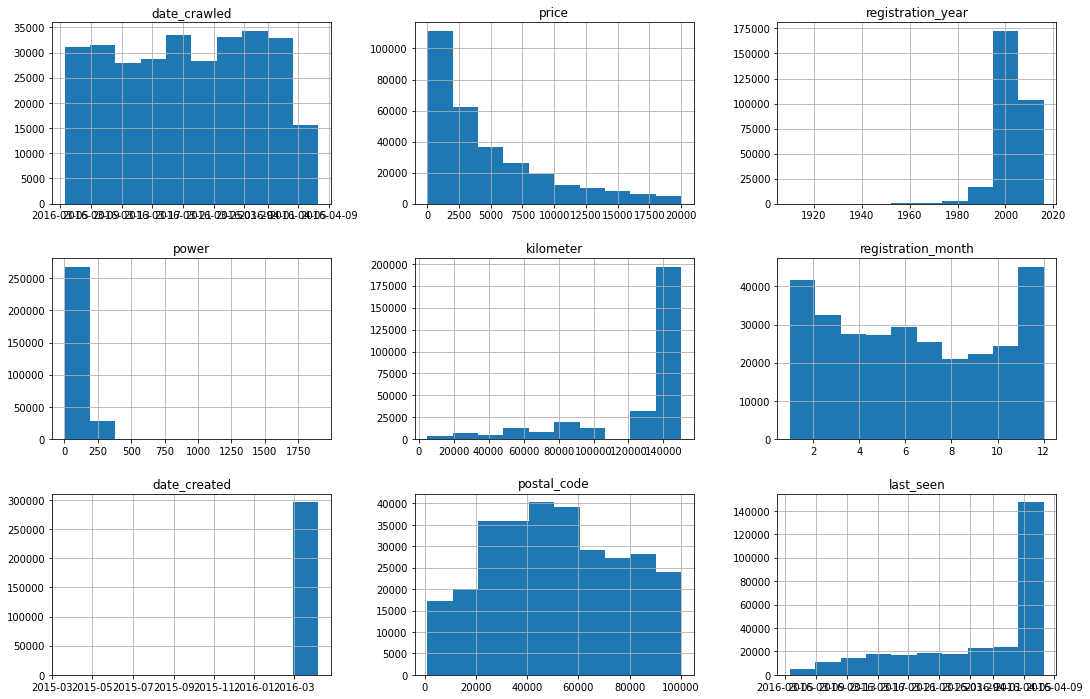

In [34]:
data.hist(figsize = (18,12));
data.describe(percentiles = [0.25,0.5,0.75,0.9,0.95,0.99])

Теперь гораздо адекватнее.

### Вывод:

- Исключены дубликаты, выбросы, устранены пропуски в категориальных переменных.

## Обучение моделей

### Подготовка признаков

Сначала отбросим признаки, которые используются для идентификации каждого объявления, затем проверим, нет ли дубликатов, и разделим признаки на обучающие и целевой, затем разделим на тренировочную, валидационную и тестовую выборки.  

Затем закодируем категориальные признаки с помощью BinaryEncoder, раздельно на каждой выборке для исключения утечки информации из тренировочных данных в тестовые. 

In [35]:
features = data.drop(columns = ['price','date_crawled', 'date_created', 'last_seen'])
target = data['price']

for feature in [features,target]:
    display(feature.shape)

(296777, 11)

(296777,)

In [36]:
features.duplicated().sum()

29413

In [37]:
target = target.drop(index = features[features.duplicated() == True].index)
features = features.drop_duplicates().reset_index(drop=True)

for element in ['features','target']:
    print(f"{element}:")
    print(eval(element).shape)

features:
(267364, 11)
target:
(267364,)


In [38]:
features_train, features_test, target_train, target_test = train_test_split(features, target,\
                                                                                    test_size=0.2,random_state=1234)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train,\
                                                                                    test_size=0.25,random_state=1234)

sample_list = ['train','valid','test']
split_list = ['features', 'target']

for sample in sample_list:
    for split in split_list:
        print (f'Length of {split}_{sample}:', len(eval(''.join([split,'_',sample]))),'\n')

Length of features_train: 160418 

Length of target_train: 160418 

Length of features_valid: 53473 

Length of target_valid: 53473 

Length of features_test: 53473 

Length of target_test: 53473 



In [39]:
be = BinaryEncoder(cols = cat_features, 
                   handle_unknown = 'indicator', 
                   handle_missing ='indicator')

features_train = be.fit_transform(features_train)
features_train.shape

(160418, 45)

In [40]:
features_valid = be.transform(features_valid)
features_test = be.transform(features_test)

for f in [features_valid,features_test]:
    print(f.shape)

(53473, 45)
(53473, 45)


С помощью BinaryEncoder мы закодировали все наши уникальные значения всего 45 столбцами вместо 8450! 

Теперь приступим к обучению моделей. Перебирать значения гиперпараметров будем с помощью BayesSearchCV, для этого впоследствии объединим валидационную и тренировочную выборки.

Также создадим датафрейм для сохранения результатов каждой модели. 

### Линейная регрессия 
Первой опробуем модель линейной регрессии.

In [41]:
model = LinearRegression()

start = time.time()
model.fit(features_train, target_train)
stop = time.time()

fit_time = stop-start

prediction = model.predict(features_valid)
score = mse(target_valid, prediction)**0.5
lin_dict= {'score':score,'learn_time':fit_time,'fit_time':fit_time,'params':'', 'model':model}
print (f"Для модели линейной регрессии RMSE = {score:0.2f} за {fit_time:0.2f} сек.")

Для модели линейной регрессии RMSE = 3075.12 за 1.31 сек.


Теперь, как и планировалось, объединяем тренировочную и валидационную выборку обратно для кросс-валидации.

In [42]:
features_train =  pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

Используем callback для ограничения времени работы функции подбора гиперпараметров (когда дельта между лучшими результатами будет не больше заданного значения - функция остановит работу)

Также напишем собственно рабочую функцию *search-time-save* - она будет искать гиперпараметры, мерить время подбора и обучения и сохранять всё это.

In [53]:
callback = DeltaYStopper(delta=200)  

In [51]:
def search_time_save(model, parameters, features = features_train,target = target_train):
    grid = BayesSearchCV(model, parameters, 
                         scoring = 'neg_root_mean_squared_error', cv=3, verbose = 1)
    start = time.time()
    grid.fit(features, target, callback = callback)
    stop = time.time()
    
    learn_time = stop-start
    
    score = abs(grid.best_score_)
    print()
    print (f"Для выбранной модели наилучший результат = {score:0.2f} за {learn_time:0.2f} сек.")
    model_dict = {'score':score,
                  'learn_time':learn_time,
                  'fit_time':grid.refit_time_,
                  'params':grid.best_params_,
                  'model':grid.best_estimator_}
    return model_dict

### Случайное дерево

In [54]:
model = DecisionTreeRegressor()

parameters = {'max_depth': [*range (1,31)],
             'random_state': [STATE]}

tree_dict  = search_time_save(model, parameters)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Для выбранной модели наилучший результат = 1991.43 за 22.75 сек.


### Случайный лес

In [55]:
model = RandomForestRegressor()

parameters = {'n_estimators': [*range(50,150,10)],
             'max_depth': [*range (8,12)],
             'random_state': [STATE]}

forest_dict = search_time_save(model, parameters)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Для выбранной модели наилучший результат = 1843.80 за 982.25 сек.


In [56]:
model = lgb.LGBMRegressor(boosting_type='gbdt', objective = 'regression', metric = 'RMSE')

parameters =  {'learning_rate':[0.05,0.1,0.15],
              'random_state': [STATE],
              'n_estimators':[*range(50,150,10)],
              'min_child_samples':[*range(20,50,10)]
}

lgb_dict = search_time_save(model, parameters)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Для выбранной модели наилучший результат = 1694.33 за 93.60 сек.


Сведём всё в один датафрейм.

In [60]:
dict_list = [lin_dict, tree_dict, forest_dict, lgb_dict]

model_scores = pd.DataFrame(dict_list, index = ['lin','tree','forest','lgb']).drop(columns=['params','model'])\
.sort_values(by='score')
model_scores

,score,learn_time,fit_time
lgb,1694.333106,93.597274,6.206894
forest,1843.800662,982.254012,104.429643
tree,1991.430966,22.753519,1.401616
lin,3075.116825,1.312763,1.312763



Лучшие результаты по сочетанию точности и скорости подбора параметров показала модель LightGBM. Попробуем отдельно посмотреть на время предсказания моделей с наилучшими параметрами. Хорошо, что мы их сохранили.

In [58]:
predict_time_list = []

for model in tqdm(model_scores.index):
    model = eval('_'.join([model,"dict['model']"]))
    start = time.time()
    
    # мы здесь используем валидационную выборку, которую ранее, до кросс-валидации, присовокупили к тренировочной.
    # мне это не нравится, но поскольку цель не получить оценку точности модели, а просто замерить время её работы,
    # закрыл на это глаза. 
    
    prediction = model.predict(features_valid)
    stop = time.time()
    predict_time_list.append(stop-start)

model_scores['best_model_predict_time'] = predict_time_list
model_scores

  0%|          | 0/4 [00:00<?, ?it/s]

,score,learn_time,fit_time,best_model_predict_time
lgb,1694.333106,93.597274,6.206894,0.362877
forest,1843.800662,982.254012,104.429643,0.687753
tree,1991.430966,22.753519,1.401616,0.014453
lin,3075.116825,1.312763,1.312763,0.010465


Этого достаточно для вывода.

In [77]:
best_model = lgb_dict['model']

### Вывод:

- Были изучены четыре модели: линейная регрессия, случайное дерево, случайный лес и LGBM. 
- Наилучшая точность предсказаний - у LGBM. 
- Лучшее время обучения и предсказания - у модели случайного дерева.
- По соотношению точности и скорости лучший результат - у LGBM.

## Анализ моделей

Теперь проверим выбранную модель на тестовой выборке.

In [78]:
test_predictions = best_model.predict(features_test)
test_score = mse(target_test,test_predictions)**0.5
print(f'На тестовой выборке результат наилучшей модели = {test_score:.2f}')

На тестовой выборке результат наилучшей модели = 1682.24


Сравним с Dummy:

In [79]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
predicted_dummy = dummy_regr.predict(features_test)
test_score = mse(target_test,predicted_dummy)**0.5
print(f'На тестовой выборке результат Dummy Regressor = {test_score:.2f}')

На тестовой выборке результат Dummy Regressor = 4602.77


### Вывод:
- Результат LGBM подтверждён на тестовой выборке.

## Общий вывод

- Были проанализированы и обработаны данные.
- Были обучены и сопоставлены модели.
- Наилучшие результаты по соотношению скорости и времени показала модель LGBM